# Quantitative Macroeconomics - Problem Set 2 - Exercise 1

### Ignasi Merediz-Solà

### Prof. Raül Santaeulàlia-Llopis

In [69]:
# I first import the required (and some other) packages
import pandas as pd
import numpy as np
import mpmath as mp
import sympy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import *

#### Part a)

In [70]:
# Definition of the parameters according to the exercise
θ = 0.67
h_t = 0.31

# We normalize production equal to 1
y_ss = 1

# We set the capital we have found in the analytical part of the exercise
k_ss = 4

# We follow by setting the delta we have also found analytically
δ = 0.25/4

# We can also get consumtpion in the steady state
c_ss = y_ss - δ*k_ss

#Investment (savings)
i_ss = y_ss - c_ss

# From the production function, we can get z:
z = pow(k_ss, ((θ - 1)/θ))*pow(h_t,-1)

# We now solve for beta by using the Euler Equation
def euler(β):
    f = (1/β) - (1-θ)*pow((z*h_t)/(k_ss), θ) - 1 + δ # Setting the Euler = 0
    return f

beta_guess = np.array([1])
beta = fsolve(euler, beta_guess)
β = beta[0]

print('Summary of the results:')
print(f'z is {z: .4f}')
print(f'Delta is {δ: .4f}')
print(f'Beta is {β: .4f}')
print((f'Production is 1.0000'))
print(f'Capital is {k_ss: .4f}')
print(f'Consumption is {c_ss: .4f}')
print(f'Investment is {i_ss: .4f}')

Summary of the results:
z is  1.6297
Delta is  0.0625
Beta is  0.9804
Production is 1.0000
Capital is  4.0000
Consumption is  0.7500
Investment is  0.2500


#### Part b)

In [71]:
# Now, we solve for the same model but doubling z

z_partb = 2*z

# We first solve for the capital in the new steady state, given that we already now beta from the previous exercise

def euler(k):
    f = (1/β) - (1-θ)*pow((z_partb*h_t)/(k), θ) - 1 + δ # Setting the Euler = 0
    return f

k_guess = np.array([1])
k = fsolve(euler, k_guess)
k = k[0]

# Production
y_partb = pow(k, 1-θ)*pow(z_partb*h_t, θ)
# Consumtpion
c_partb = y_partb - δ*k
# Investmentt
i_partb = y_partb - c_partb 

print('Summary of the results in the new steady state:')
print(f'New z is {z_partb: .4f}')
print(f'New delta is {δ: .4f}')
print(f'Beta is {β: .4f}')
print((f'New Production {y_partb: .4f}'))
print(f'New capital is {k: .4f}')
print(f'New consumption is {c_partb: .4f}')
print(f'New investment is {i_partb: .4f}')

Summary of the results in the new steady state:
New z is  3.2594
New delta is  0.0625
Beta is  0.9804
New Production  2.0000
New capital is  8.0000
New consumption is  1.5000
New investment is  0.5000


#### Part c)

In order to solve this part and part d, we have to program this model in order to study the evolution of the variables between the two steady states. I am gonna to do so with a Class.

In [72]:
from scipy import optimize

class Model(object):

    def __init__(self, params, k=None, c=None):
            """
            Represents the Ramsey model 

            Definition of exogenous parameters of the Ramsey Model
                1) theta: labor share.  
                2) beta: discount factor
                3) z: initial level of technology
                4) delta: rate of capital depreciation
                5) h: hours of labor (hours available normalized to 1)


            Attributes: 
                1) params: a dictionary of parameters and their values
                2) k: an initial condition for the state variable k 
                3) c: an initial condition for the control variable c

            """
            # Current value of state variable, k
            self.k = k
            # Current value of the control variable, c
            self.c = c
            # Cictionary of parameter values
            self.param_dict = params
            #Cdictionary of steady state values        
            self.SS_dict = {'k_star':self.set_k_star(self.param_dict), 
                            'c_star':self.set_c_star(self.param_dict)}


    def set_k_star(self, params): 
            """
            Steady-state level of capital stock.
            """
            # I extract the required parameters
            δ = params['delta']
            β   = params['beta']
            θ = params['theta']
            h = params ['h']
            z = params ['z']


            return pow(((1-θ)/((1/β)+δ-1)), (1/θ))*(z*h)

    def set_c_star(self, params): 
            """
            Steady-state level of consumption.
            """
            # I extract the required parameters
            θ = params['theta']
            h = params ['h']
            δ  = params['delta']
            z = params ['z']
            k_star = self.set_k_star(params)

            return pow(k_star, 1-θ)*pow(z*h, θ) - δ*k_star

    def capital(self, k, c):
        """
        Law of motion of capital.
        Inputs: k_t, c_t
        Output: k_t+1
        """
        # I extract the required parameters
        θ = self.param_dict['theta']
        δ = self.param_dict['delta']
        h = self.param_dict['h']
        z = self.param_dict['z']
    
        return pow(k, 1-θ)*pow(z*h, θ) - c + (1-δ)*k
 
    def euler(self, k, c):
        """
        Euler equation, which shows the inter-temporal trade-off between today's and tomorrow's  consumption.
        Inputs: k_{t+1}, c_t
        Output: c_{t+1}      
        """
        # extract params
        h = self.param_dict['h']
        z = self.param_dict['z']
        δ = self.param_dict['delta']
        θ = self.param_dict['theta']
        β = self.param_dict['beta']
    
        return c*β*(1 - δ + (1-θ)*pow(z*h, θ)*pow(k, -θ))

    def nextperiod(self):
        """
        Update the state and control variables. It is crucial to first update the capital and then the consumption.          
        """
        self.k = self.capital(self.k, self.c) 
        self.c = self.euler(self.k, self.c)

    def sample_path(self, n=None):
        """
        Generate sample path of length n starting from the current state.
        """
        path = np.zeros(shape=(n, 2))
        
        for t in range(n):
            path[t, 0] = self.k
            path[t, 1] = self.c
            self.nextperiod()
        
        return path

    def steady(self, k0=None, c0=None):
        """     
        Finds the steady state for this economy using a root solver and an initial guess.        
        """
        
        def modelSS(x): 
            out = [self.capital(x[0], x[1]) - x[0]] # k_t+1=k_t
            out.append(self.euler(x[0], x[1]) - x[1]) # c_t+1=c_t
            return out
        x = optimize.fsolve(func=modelSS, x0=(k0, c0))
        return x

    def forward_shoot(self, k0=None, c0=None, tol=1.5e-08):
        """       
        Computes the full, non-linear saddle path for the model using the 'forward shooting' algorithm (from Judd (1992)).         
        """
        # I extract the required parameters
        θ = self.param_dict['theta']
        h = self.param_dict['h']
        z = self.param_dict['z']
        
        # I compute steady state values
        k_star, c_star = self.SS_dict['k_star'], self.SS_dict['c_star']
        
        if k0 <= k_star:
            c_l = 0
            c_h = c_star
        else:
            c_l = c_star
            c_h = pow(k0, 1-θ)*pow(z*h, θ) # Production
        c0 = (c_h + c_l) / 2
        self.k, self.c = k0, c0
        
        # Initialize a counter
        count  = 0
        n_iter = 0

        # Forward Shooting Algorithm
        while True:
            self.nextperiod()
            dist = np.abs(((self.k - k_star)**2 + (self.c - c_star)**2)**0.5)
            count = count + 1
            if k0 <= k_star:
                if self.k > k_star:
                    if dist < tol:
                        break
                    else: # initial c_l too low!
                        c_l = c0
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                if self.c > c_star:
                    if dist < tol:
                        break
                    else: # initial c_h too high!
                        c_h = c0 
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
            else:
                if self.k < k_star:
                    if dist < tol:
                        break
                    else: # initial c_l too high!
                        c_h = c0 
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                if self.c < c_star:
                    if dist < tol:
                        break
                    else: # initial c_l too low!
                        c_l = c0
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                
        self.k, self.c = k0, c0
        solutionPath = self.sample_path(count)


        return [self.c, solutionPath, count, dist]    

## Plotting the transition

Now, I have been able to define the model we have for this Problem Set (I have checked that the results coincide with those I have found in part a and b), so that now I am able to calculate the transitions.

In [73]:
# Steady state of section 1b) Shock over productivity. 
θ = 0.67
h = 0.31
β = 0.9804
δ = 0.0625 # Since we know it from part a
params = {'theta':θ, 'delta':δ, 'h':h, 'beta':β, 'z':3.2594}
model = Model(params)
solution=model.steady(k0=3, c0=3)

k_ss=solution[0]
c_ss=solution[1]
y_ss=δ*k_ss+c_ss
v=k_ss/y_ss
t=δ*k_ss/y_ss
print ("SS capital=", "{0:.2f}".format(solution[0]))
print ("SS consumption=", "{0:.2f}".format(solution[1]))
print ("SS output=", "{0:.2f}".format(y_ss))
print ("capital/output=", "{0:.2f}".format(v))
print ("investment/output", "{0:.2f}".format(t))

SS capital= 8.00
SS consumption= 1.50
SS output= 2.00
capital/output= 4.00
investment/output 0.25


In [74]:
#Set the new set of parameters
params = {'theta':θ, 'delta':δ, 'h':h, 'beta':β, 'z':3.2594}
model = Model(params)

# Solve for the non-linear saddle path
transition_1 = model.forward_shoot(k0 = 4, tol = 1.5e-4) # We know the initial values of the first steady state
# This model already indicates us that the steady state has been reached in 98 periods so that we can use this information to then set the graphs

transition_1 = transition_1[1] #Since we are interested in the transition path

#Transition values for output
y1=[]
for i in range(0,98):
    y=transition_1[i,0]**(1-θ)*(3.2594*h)**θ
    y1.append(y)
    
#Transitions for capital, consumption and savings
k_transition=transition_1[:,0]
c_transition=transition_1[:,1] 
s_transition=[]
for i in range (0,98):
    s = y1[i]-c_transition[i]
    s_transition.append(s)

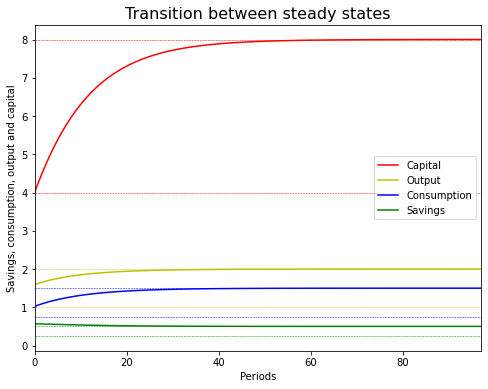

In [75]:
# PLOT
line_k = np.ones(98)*4 #Initial value of the previous steady state (for capital)
line_y=np.ones(98)*1 #Initial value of the previous steady state (for output)
line_c= np.ones(98)*0.75 #Initial value of the previous steady state (for consumtpion)
line_s=np.ones(98)*0.25 #Initial values of the previous steady state (for savings)
line_k2 = np.ones(98)*8 #Initial value of the previous steady state (for capital)
line_y2=np.ones(98)*2 #Initial value of the previous steady state (for output)
line_c2= np.ones(98)*1.5 #Initial value of the previous steady state (for consumtpion)
line_s2=np.ones(98)*0.5 #Initial values of the previous steady state (for savings)

fig = plt.figure(figsize=(8,6))
grid = np.arange(0, 98, 1)

plt.plot(grid, k_transition, 'r', label='Capital')
plt.plot(grid, y1, color='y', label='Output')
plt.plot(grid, c_transition, color='b', label='Consumption')
plt.plot(grid, s_transition, color='g', label='Savings')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_y, 'y--',linewidth=0.5 )
plt.plot(grid, line_c, 'b--',linewidth=0.5 )
plt.plot(grid, line_s, 'g--',linewidth=0.5 )
plt.plot(grid, line_k2, 'r--', linewidth=0.5)
plt.plot(grid, line_y2, 'y--',linewidth=0.5 )
plt.plot(grid, line_c2, 'b--',linewidth=0.5 )
plt.plot(grid, line_s2, 'g--',linewidth=0.5 )
plt.xlabel('Periods')
plt.ylabel('Savings, consumption, output and capital')
plt.xlim(0, 97)
plt.legend(loc = 'center right')
plt.title('Transition between steady states', fontsize=16)

#Save the plot
plt.savefig('1.c_figure.png')

plt.show()


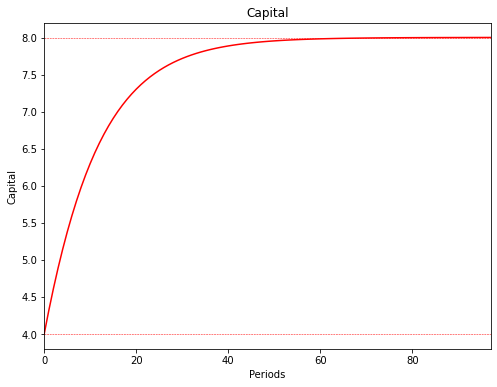

In [76]:
#Four subplots of the tranisiton
fig = plt.figure(figsize=(8,6))
plt.plot(grid, k_transition, 'r', label='Capital')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_k2, 'r--', linewidth=0.5)
plt.title('Capital')
plt.xlabel('Periods')
plt.ylabel('Capital')
plt.xlim(0, 97)

plt.savefig('1.c_zoom_K_figure.png')

plt.show()

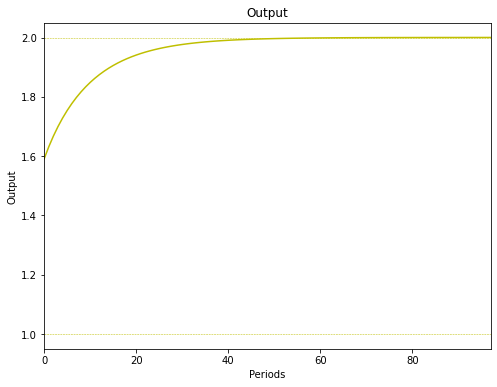

In [77]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, y1, 'y')
plt.plot(grid, line_y, 'y--', linewidth=0.5)
plt.plot(grid, line_y2, 'y--', linewidth=0.5)
plt.title('Output')
plt.xlabel('Periods')
plt.ylabel('Output')
plt.xlim(0, 97)

plt.savefig('1.c_zoom_Y_figure.png')

plt.show()

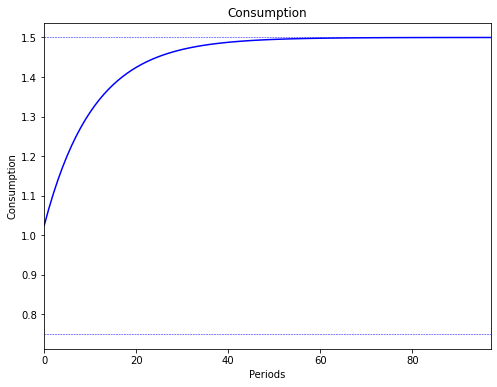

In [78]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, c_transition, 'b')
plt.plot(grid, line_c, 'b--', linewidth=0.5)
plt.plot(grid, line_c2, 'b--', linewidth=0.5)
plt.title('Consumption')
plt.xlabel('Periods')
plt.ylabel('Consumption')
plt.xlim(0, 97)

plt.savefig('1.c_zoom_C_figure.png')

plt.show()

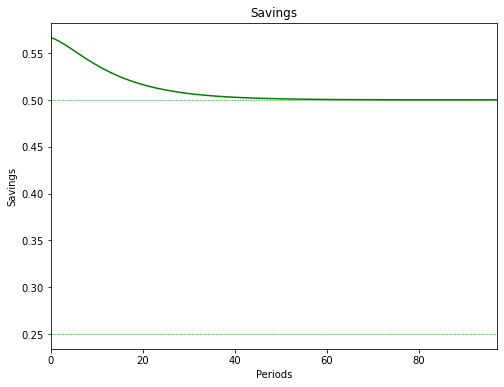

In [79]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, s_transition, 'g', label='Savings')
plt.plot(grid, line_s, 'g--', linewidth=0.5)
plt.plot(grid, line_s2, 'g--', linewidth=0.5)
plt.title('Savings')
plt.xlabel('Periods')
plt.ylabel('Savings')
plt.xlim(0, 97)

#Save the plot
plt.savefig('1.c_zoom_S_figure.png')

plt.show()


## Part d)

Here, I am gonna to continue from part c) to keep the equilibrium for 10 periods and then return back to the equilibrium of c and check the evolution graphically.

In [80]:
# We set the variables of the new steady state
k_ss = 8
c_ss = 1.5
s_ss = 0.5
y_ss = 2

# We repeat this allocation for ten periods
Path_k = np.repeat(k_ss, 10)
Path_c = np.repeat(c_ss, 10)
Path_s = np.repeat(s_ss, 10)
Path_y = np.repeat(y_ss, 10)

# We repeat the same process as before
params = {'theta':θ, 'delta':δ, 'h':h, 'beta':β, 'z':1.6297}
model = Model(params)

# Solve for the non-linear saddle path
transition_2 = model.forward_shoot(k0 = k_ss, tol=1.5e-4) # We know the initial values of the first steady state

# This model already indicates us that the steady state has been reached in 96 periods so that we can use this information to then set the graphs
transition_2 = transition_2[1] #Since we are interested in the Transition Path

#Transition values for output
y2=[]
for i in range(0,96):
    q=transition_2[i,0]**(1-θ)*(1.6297*h)**θ
    y2.append(q)

#Transitions for capital, consumption and savings
k_transition_2 = transition_2[:,0]
c_transition_2 = transition_2[:,1] 
s_transition_2 = []
for i in range (0,96):
    s = y2[i]-c_transition_2[i]
    s_transition_2.append(s)
    
# I put together the ten periods in the period with the change in the productivity shock.
k_transition_2 = np.concatenate((Path_k, k_transition_2))
c_transition_2 = np.concatenate((Path_c, c_transition_2))
y2 = np.concatenate((Path_y, y2))
s_transition_2 = np.concatenate((Path_s, s_transition_2))

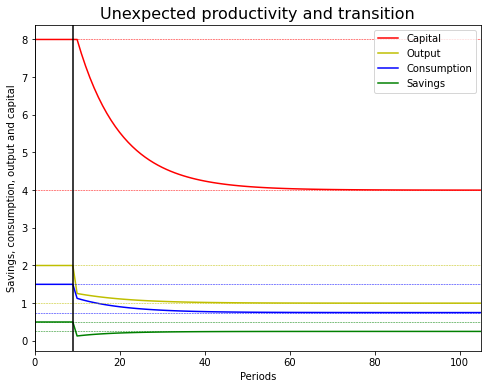

In [81]:
# PLOT
line_k = np.ones(106)*4 #Initial value of the previous steady state (for capital)
line_y=np.ones(106)*1 #Initial value of the previous steady state (for output)
line_c= np.ones(106)*0.75 #Initial value of the previous steady state (for consumtpion)
line_s=np.ones(106)*0.25 #Initial values of the previous steady state (for savings)
line_k2 = np.ones(106)*8 #Initial value of the previous steady state (for capital)
line_y2 = np.ones(106)*2 #Initial value of the previous steady state (for output)
line_c2 = np.ones(106)*1.5 #Initial value of the previous steady state (for consumtpion)
line_s2 = np.ones(106)*0.5 #Initial values of the previous steady state (for savings)

fig = plt.figure(figsize=(8,6))
grid = np.arange(0, 106, 1)
plt.plot(grid, k_transition_2, 'r', label='Capital')
plt.plot(grid, y2, color='y', label='Output')
plt.plot(grid, c_transition_2, color='b', label='Consumption')
plt.plot(grid, s_transition_2, color='g', label='Savings')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_y, 'y--',linewidth=0.5 )
plt.plot(grid, line_c, 'b--',linewidth=0.5 )
plt.plot(grid, line_s, 'g--',linewidth=0.5 )
plt.plot(grid, line_k2, 'r--', linewidth=0.5)
plt.plot(grid, line_y2, 'y--',linewidth=0.5 )
plt.plot(grid, line_c2, 'b--',linewidth=0.5 )
plt.plot(grid, line_s2, 'g--',linewidth=0.5 )
plt.axvline(0, color='black')
plt.axvline(9, color='black')
plt.xlabel('Periods')
plt.ylabel('Savings, consumption, output and capital')
plt.xlim(0, 105)
plt.legend(loc = 'upper right')
plt.title('Unexpected productivity and transition', fontsize=16)

#Save the plot
plt.savefig('1.d_figure.png')

plt.show()

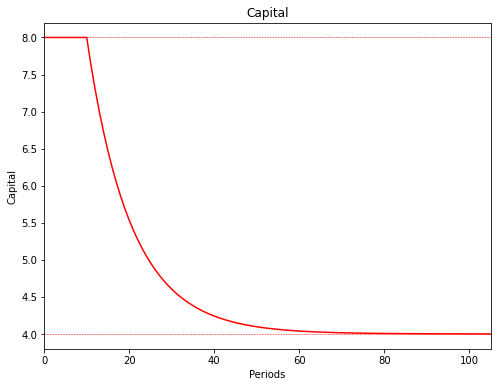

In [82]:
#Four subplots of the tranisiton
fig = plt.figure(figsize=(8,6))
plt.plot(grid, k_transition_2, 'r', label='Capital')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_k2, 'r--', linewidth=0.5)
plt.title('Capital')
plt.xlabel('Periods')
plt.ylabel('Capital')
plt.xlim(0, 105)

plt.savefig('1.d_zoom_K_figure.png')

plt.show()

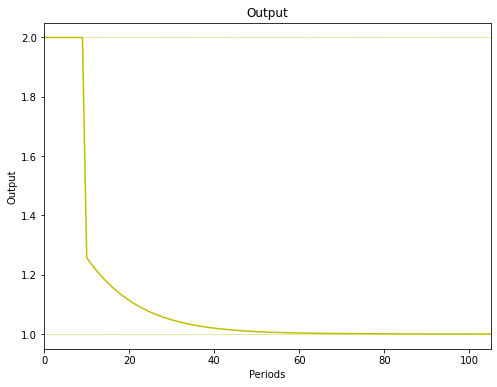

In [83]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, y2, 'y')
plt.plot(grid, line_y, 'y--', linewidth=0.5)
plt.plot(grid, line_y2, 'y--', linewidth=0.5)
plt.title('Output')
plt.xlabel('Periods')
plt.ylabel('Output')
plt.xlim(0, 105)

plt.savefig('1.d_zoom_Y_figure.png')

plt.show()

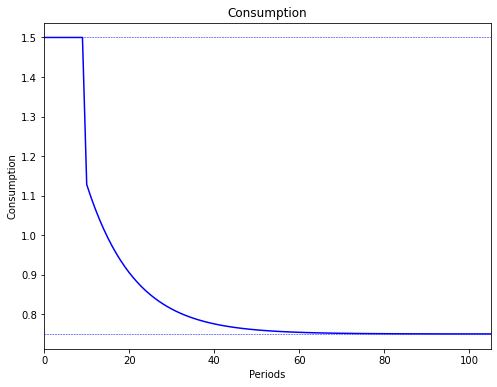

In [84]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, c_transition_2, 'b')
plt.plot(grid, line_c, 'b--', linewidth=0.5)
plt.plot(grid, line_c2, 'b--', linewidth=0.5)
plt.title('Consumption')
plt.xlabel('Periods')
plt.ylabel('Consumption')
plt.xlim(0, 105)

plt.savefig('1.d_zoom_C_figure.png')

plt.show()


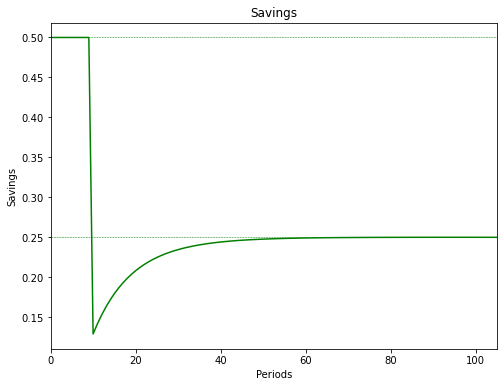

In [85]:
fig = plt.figure(figsize=(8,6))
plt.plot(grid, s_transition_2, 'g', label='Savings')
plt.plot(grid, line_s, 'g--', linewidth=0.5)
plt.plot(grid, line_s2, 'g--', linewidth=0.5)
plt.title('Savings')
plt.xlabel('Periods')
plt.ylabel('Savings')
plt.xlim(0, 105)

#Save the plot
plt.savefig('1.d_zoom_S_figure.png')

plt.show()



## Combination of part c) and part d) graphs

In this part, I am gonna to combine the graphs of part c) and part d) into a unique figure to show the evolution of the variables from one steady state to another and then back again to the first steady state.

In [86]:
# I put together the results from part c) and d)
k_transition_cd = np.concatenate((k_transition, k_transition_2))
c_transition_cd = np.concatenate((c_transition, c_transition_2))
y_cd = np.concatenate((y1, y2))
s_transition_cd = np.concatenate((s_transition, s_transition_2))

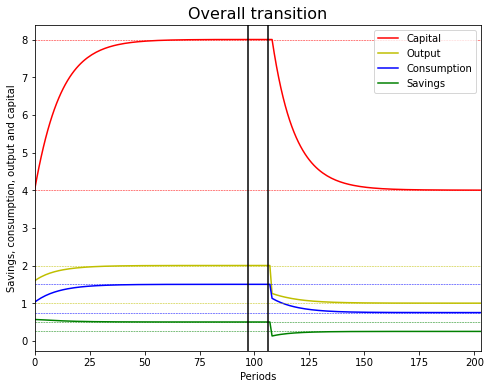

In [87]:
# PLOT
line_k = np.ones(204)*4 #Initial value of the previous steady state (for capital)
line_y = np.ones(204)*1 #Initial value of the previous steady state (for output)
line_c = np.ones(204)*0.75 #Initial value of the previous steady state (for consumtpion)
line_s = np.ones(204)*0.25 #Initial values of the previous steady state (for savings)
line_k2 = np.ones(204)*8 #Initial value of the previous steady state (for capital)
line_y2 = np.ones(204)*2 #Initial value of the previous steady state (for output)
line_c2 = np.ones(204)*1.5 #Initial value of the previous steady state (for consumtpion)
line_s2 = np.ones(204)*0.5 #Initial values of the previous steady state (for savings)


fig = plt.figure(figsize=(8,6))
grid = np.arange(0, 204, 1)
plt.plot(grid, k_transition_cd, 'r', label='Capital')
plt.plot(grid, y_cd, color='y', label='Output')
plt.plot(grid, c_transition_cd, color='b', label='Consumption')
plt.plot(grid, s_transition_cd, color='g', label='Savings')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_y, 'y--',linewidth=0.5)
plt.plot(grid, line_c, 'b--',linewidth=0.5)
plt.plot(grid, line_s, 'g--',linewidth=0.5)
plt.plot(grid, line_k2, 'r--', linewidth=0.5)
plt.plot(grid, line_y2, 'y--',linewidth=0.5 )
plt.plot(grid, line_c2, 'b--',linewidth=0.5 )
plt.plot(grid, line_s2, 'g--',linewidth=0.5 )
plt.axvline(97, color='black')
plt.axvline(106, color='black')
plt.xlabel('Periods')
plt.ylabel('Savings, consumption, output and capital')
plt.xlim(0, 203)
plt.legend(loc = 'upper right')
plt.title('Overall transition', fontsize=16)

#Save the plot
plt.savefig('overall_transition.png')

plt.show()

## Alternative way to do the transition

In this part, I am gonna to assume a different setup. That is, agents believe they are heading the new steady state (but indeed they neve reached). Then, suddenly, they go the the previous steady state.

In [88]:
# First, we need to get the first ten observation of the first transition to the steady state and store the tenth value.

k_transition_extra = k_transition[0:10]
c_transition_extra = c_transition[0:10]
s_transition_extra = s_transition[0:10]
y_extra = y1[0:10]

k_value = k_transition_extra[9]
c_value = c_transition_extra[9]

# We repeat the same process as before
params = {'theta':θ, 'delta':δ, 'h':h, 'beta':β, 'z':1.6297}
model = Model(params)

transition_extra = model.forward_shoot(k0 = k_value, tol = 1.5e-4) # We know the initial values until the unexpected shock happens.
# This model already indicates us that the steady state has been reached in 89 periods so that we can use this information to then set the graphs
transition_extra = transition_extra[1] #Since we are interested in the Transition Path

#Transition values for output
y_extra_2=[]
for i in range(0,89):
    q=transition_extra[i,0]**(1-θ)*(1.6297*h)**θ
    y_extra_2.append(q)

#Transitions for capital, consumption and savings
k_transition_extra_2 = transition_extra[:,0]
c_transition_extra_2 = transition_extra[:,1] 
s_transition_extra_2 = []
for i in range (0,89):
    s = y_extra_2[i]-c_transition_extra_2[i]
    s_transition_extra_2.append(s)
    
# I put together the ten periods in the period with the change in the productivity shock.
k_2 = np.concatenate((k_transition_extra, k_transition_extra_2))
c_2 = np.concatenate((c_transition_extra, c_transition_extra_2))
y_3 = np.concatenate((y_extra, y_extra_2))
s_2 = np.concatenate((s_transition_extra, s_transition_extra_2))

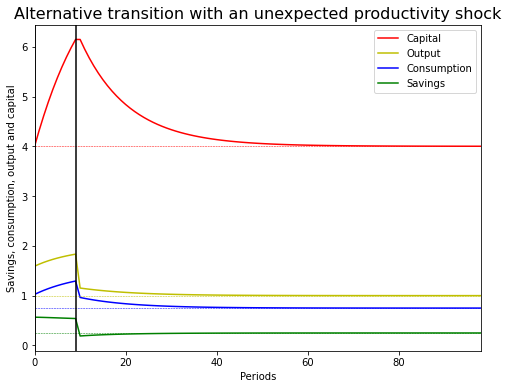

In [89]:
line_k = np.ones(99)*4 #Initial value of the previous steady state (for capital)
line_y = np.ones(99)*1 #Initial value of the previous steady state (for output)
line_c = np.ones(99)*0.75 #Initial value of the previous steady state (for consumtpion)
line_s = np.ones(99)*0.25 #Initial values of the previous steady state (for savings)


fig = plt.figure(figsize=(8,6))
grid = np.arange(0, 99, 1)
plt.plot(grid, k_2, 'r', label='Capital')
plt.plot(grid, y_3, color='y', label='Output')
plt.plot(grid, c_2, color='b', label='Consumption')
plt.plot(grid, s_2, color='g', label='Savings')
plt.plot(grid, line_k, 'r--', linewidth=0.5)
plt.plot(grid, line_y, 'y--',linewidth=0.5)
plt.plot(grid, line_c, 'b--',linewidth=0.5)
plt.plot(grid, line_s, 'g--',linewidth=0.5)
plt.axvline(0, color='black')
plt.axvline(9, color='black')
plt.xlabel('Periods')
plt.ylabel('Savings, consumption, output and capital')
plt.xlim(0, 98)
plt.legend(loc = 'upper right')
plt.title('Alternative transition with an unexpected productivity shock', fontsize=16)

#Save the plot
plt.savefig('alternative transition.png')

plt.show()

### Part e)

In this part, I am gonna to try to model this same economy with flexible labor supply ($h_{t}$ we have been using during the previous exercises. Thus, now $h_t$ is not longer a parameter of the model but a decision that the agent has to make.